# Assignment 4

## Multi-Class Text Classification

In [1]:
# import the necessary libraries
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
from plotnine import *
import matplotlib.pyplot as plt
import pandas
import numpy
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import array
from tensorflow.keras.utils import to_categorical

In [26]:
# import ntlk library and stopwords function
# English stopwords: has, hasn’t, and, aren’t, because, each, during

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/iman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Set Hyper-Parameters required to build and train the model
vocab_size = 5000 # make the top list of words (common words)
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary
training_portion = .8

In [28]:
# Populate List and Remove the Stopwords
    # populate the list of articles and labels from the data and also remove the stopwords

articles = []
labels = []

# pd.read_csv('bbc-text.csv', sep='|', names=m_cols , encoding='latin-1')
# pd.read_csv('bbc-text.csv',encoding='latin-1')

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)

In [29]:
print("length of labels: ", len(labels))
print("length of articles: ", len(articles))

length of labels:  2225
length of articles:  2225


In [30]:
# Creating Training and Validation Set
    # 80% (training_portion = .8) for training and 20% for validation.

train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

In [31]:
print("Train Size: ", train_size)
print(f"Train Articles: {len(train_articles)}")
print("Train Labels: ", len(train_labels))
print("Validation Articles: ", len(validation_articles))
print("Validation Labels: ", len(validation_labels))

Train Size:  1780
Train Articles: 1780
Train Labels:  1780
Validation Articles:  445
Validation Labels:  445


In [32]:
# Tokenization
    # we set the tokenization with num_words is vocab_size (5000), and oov_token is ‘<OOV>’
    # if we give the text “The cat sat on the mat.”, it will create a dictonary {‘<OOV>’: 1, ‘cat’: 3, ‘mat’: 6, ‘on’: 5, ‘sat’: 4, ‘the’: 2}

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok) # oov_token is the value ‘<OOV>’ that we put if the word is not listed in the dictionary
tokenizer.fit_on_texts(train_articles) # this method creates the vocabulary index based on word frequency
word_index = tokenizer.word_index

In [33]:
# Convert to Sequences

text_sequences = tokenizer.texts_to_sequences(["the cat sat on my table"]) 
# texts_to_sequences transforms each text in texts to a sequence of integers
# if the word is not in the dictionary, it will put the value of 1
text_sequences


[[1249, 1, 1, 583, 1, 2199]]

In [34]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
train_sequences

[[91,
  160,
  1141,
  1106,
  49,
  979,
  755,
  1,
  89,
  1304,
  4289,
  129,
  175,
  3653,
  1214,
  1194,
  1575,
  42,
  7,
  893,
  91,
  1,
  334,
  85,
  20,
  14,
  130,
  3262,
  1215,
  2422,
  569,
  451,
  1375,
  58,
  3378,
  3521,
  1659,
  8,
  921,
  730,
  10,
  844,
  1,
  9,
  599,
  1576,
  1107,
  395,
  1940,
  1106,
  731,
  49,
  537,
  1397,
  2010,
  1620,
  134,
  249,
  113,
  2356,
  795,
  4981,
  980,
  584,
  10,
  3956,
  3957,
  921,
  2563,
  129,
  344,
  175,
  3653,
  1,
  1,
  39,
  62,
  2868,
  28,
  9,
  4723,
  18,
  1305,
  136,
  416,
  7,
  143,
  1423,
  71,
  4502,
  436,
  4982,
  91,
  1107,
  77,
  1,
  82,
  2011,
  53,
  1,
  91,
  6,
  1008,
  591,
  89,
  1304,
  91,
  1963,
  131,
  137,
  420,
  9,
  2869,
  38,
  152,
  1234,
  89,
  1304,
  4724,
  7,
  436,
  4982,
  3154,
  6,
  2493,
  1,
  431,
  1126,
  1,
  1424,
  570,
  1216,
  1902,
  1,
  766,
  9,
  537,
  1397,
  2010,
  134,
  2068,
  400,
  845,
  1964,
  15

In [35]:
# Sequence Truncation and Padding
# Those sequences are not in the same size
    # we need to make them in same size (concrete shape) when we train them for NLP
    # we use padding and truncate them so all sequences will be in the same size

text_padded = pad_sequences(text_sequences, maxlen=10, padding=padding_type, truncating=trunc_type)
text_padded

array([[1249,    1,    1,  583,    1, 2199,    0,    0,    0,    0]],
      dtype=int32)

In [36]:
text_padded = pad_sequences(text_sequences, maxlen=10, padding="pre", truncating="pre")
text_padded

array([[   0,    0,    0,    0, 1249,    1,    1,  583,    1, 2199]],
      dtype=int32)

In [37]:
# apply tokenization, convert to sequences and padding/truncating to train_articles and validation_articles

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [38]:
# Labels
print(set(labels))

{'sport', 'entertainment', 'politics', 'business', 'tech'}


In [39]:
# model doesn’t understand the words, so we need to convert the label into numbers
# do tokenization and convert to sequence as before
# when doing the tokenization, we don’t indicate the vocab size and oov_token.

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [40]:
label_tokenizer.word_index

{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}

In [42]:
# Create Model

model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 386,822
Trainable params: 386,822
Non-trainable params: 0
_________________________________________________________________


### Embedding Layer: 
- model begins with an embedding layer which turns the input integer indices into the corresponding word vectors
- word embedding represents a word as a vector
- word embeddings allow the value of the vector’s element to be trained
- after training, words with similar meanings often have the similar vectors

### Dropout Layer
- add the dropout layer to combat overfitting


### BiDirectional with LSTM Layer
- BiDirectional layer propagates the input forward and backwards through the LSTM layer and then concatenates the output
- helps the LSTM to learn long range dependencies


### Dense Layer
- final layer
- Dense layer with softmax activation for the multi class classification

In [43]:
# Compile the Model

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [44]:
# Train the Model
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 33s - loss: 1.5980 - accuracy: 0.2719 - val_loss: 1.3550 - val_accuracy: 0.5663 - 33s/epoch - 587ms/step
Epoch 2/10
56/56 - 23s - loss: 1.3324 - accuracy: 0.4596 - val_loss: 1.1279 - val_accuracy: 0.6427 - 23s/epoch - 407ms/step
Epoch 3/10
56/56 - 21s - loss: 0.7936 - accuracy: 0.7421 - val_loss: 0.6890 - val_accuracy: 0.8494 - 21s/epoch - 367ms/step
Epoch 4/10
56/56 - 18s - loss: 0.3019 - accuracy: 0.9421 - val_loss: 0.2733 - val_accuracy: 0.9303 - 18s/epoch - 318ms/step
Epoch 5/10
56/56 - 24s - loss: 0.1021 - accuracy: 0.9798 - val_loss: 0.2021 - val_accuracy: 0.9393 - 24s/epoch - 422ms/step
Epoch 6/10
56/56 - 20s - loss: 0.0838 - accuracy: 0.9837 - val_loss: 0.1874 - val_accuracy: 0.9461 - 20s/epoch - 364ms/step
Epoch 7/10
56/56 - 20s - loss: 0.0479 - accuracy: 0.9978 - val_loss: 0.1886 - val_accuracy: 0.9438 - 20s/epoch - 355ms/step
Epoch 8/10
56/56 - 16s - loss: 0.0334 - accuracy: 0.9966 - val_loss: 0.1425 - val_accuracy: 0.9506 - 16s/epoch - 291ms/step
Epoch 9/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


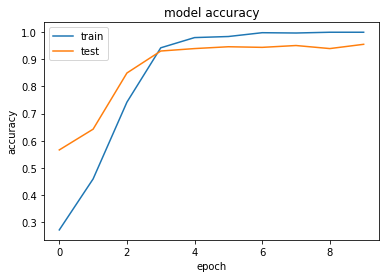

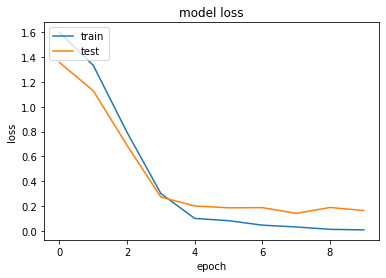

In [46]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
# Prediction
# It is correctly predicted as politics

txt = ["blair prepares to name poll date tony blair is likely to name 5 may as election day when parliament returns from its easter break  the bbc s political editor has learned.  andrew marr says mr blair will ask the queen on 4 or 5 april to dissolve parliament at the end of that week. mr blair has so far resisted calls for him to name the day but all parties have stepped up campaigning recently. downing street would not be drawn on the claim  saying election timing was a matter for the prime minister.  a number 10 spokeswoman would only say:  he will announce an election when he wants to announce an election.  the move will signal a frantic week at westminster as the government is likely to try to get key legislation through parliament. the government needs its finance bill  covering the budget plans  to be passed before the commons closes for business at the end of the session on 7 april.  but it will also seek to push through its serious and organised crime bill and id cards bill. mr marr said on wednesday s today programme:  there s almost nobody at a senior level inside the government or in parliament itself who doesn t expect the election to be called on 4 or 5 april.  as soon as the commons is back after the short easter recess  tony blair whips up to the palace  asks the queen to dissolve parliament ... and we re going.  the labour government officially has until june 2006 to hold general election  but in recent years governments have favoured four-year terms."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment'] 

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])

[[5.9485028e-05 2.7631273e-04 8.6088642e-04 9.9571866e-01 2.7188351e-03
  3.6577464e-04]]
3
politics


In [48]:
# It is correctly predicted as bussiness

txt = ["call to save manufacturing jobs the trades union congress (tuc) is calling on the government to stem job losses in manufacturing firms by reviewing the help it gives companies.  the tuc said in its submission before the budget that action is needed because of 105 000 jobs lost from the sector over the last year. it calls for better pensions  child care provision and decent wages. the 36-page submission also urges the government to examine support other european countries provide to industry. tuc general secretary brendan barber called for  a commitment to policies that will make a real difference to the lives of working people.    greater investment in childcare strategies and the people delivering that childcare will increases the options available to working parents   he said.  a commitment to our public services and manufacturing sector ensures that we can continue to compete on a global level and deliver the frontline services that this country needs.  he also called for  practical measures  to help pensioners  especially women who he said  are most likely to retire in poverty . the submission also calls for decent wages and training for people working in the manufacturing sector."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment'] 

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])

[[1.4958679e-04 8.7418033e-05 8.4733808e-01 3.6174159e-02 1.1580272e-01
  4.4793772e-04]]
2
bussiness


## Time Series Prediction with LSTM Recurrent Neural Networks

### Problem Statement:
International Airline Passengers prediction problem
- Given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

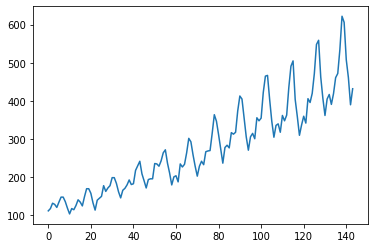

In [50]:
dataset = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

# there is an upward trend in the dataset over time
# there is some periodicity to the dataset that probably corresponds to the Northern Hemisphere vacation period

In [52]:
# LSTM Network for Regression
    # given the number of passengers (in units of thousands) this month, what is the number of passengers next month?
    # write a simple function to convert our single column of data into a two-column dataset
        # the first column containing this month’s (t) passenger count
        # the second column containing next month’s (t+1) passenger count, to be predicted

# fix the random number seed to ensure our results are reproducible
numpy.random.seed(7)

In [53]:
# load the dataset
dataframe = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [54]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [57]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("train: ", len(train))
print("test: ", len(test))

train:  96
test:  48


In [58]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [61]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [62]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [63]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 5s - loss: 0.0343 - 5s/epoch - 57ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0154 - 330ms/epoch - 4ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0129 - 353ms/epoch - 4ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0117 - 299ms/epoch - 3ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0106 - 327ms/epoch - 3ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0096 - 293ms/epoch - 3ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0085 - 493ms/epoch - 5ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0075 - 291ms/epoch - 3ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0065 - 325ms/epoch - 3ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0057 - 348ms/epoch - 4ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0049 - 264ms/epoch - 3ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0043 - 293ms/epoch - 3ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0037 - 281ms/epoch - 3ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0032 - 241ms/epoch - 3ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0028 - 364ms/epoch - 4ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0026 - 245ms/epoc

In [64]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.95 RMSE
Test Score: 49.48 RMSE


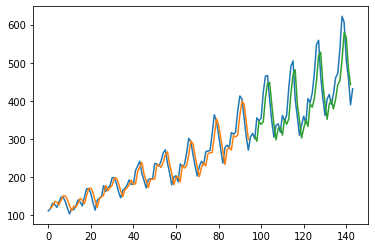

In [65]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

2022-04-06 23:58:34.601430: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
92/92 - 4s - loss: 0.0571 - 4s/epoch - 45ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0270 - 329ms/epoch - 4ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0173 - 353ms/epoch - 4ms/step
Epoch 4/100
92/92 - 1s - loss: 0.0143 - 501ms/epoch - 5ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0127 - 449ms/epoch - 5ms/step
Epoch 6/100
92/92 - 1s - loss: 0.0113 - 537ms/epoch - 6ms/step
Epoch 7/100
92/92 - 1s - loss: 0.0102 - 986ms/epoch - 11ms/step
Epoch 8/100
92/92 - 1s - loss: 0.0087 - 865ms/epoch - 9ms/step
Epoch 9/100
92/92 - 1s - loss: 0.0076 - 757ms/epoch - 8ms/step
Epoch 10/100
92/92 - 1s - loss: 0.0066 - 1s/epoch - 11ms/step
Epoch 11/100
92/92 - 1s - loss: 0.0059 - 502ms/epoch - 5ms/step
Epoch 12/100
92/92 - 1s - loss: 0.0051 - 710ms/epoch - 8ms/step
Epoch 13/100
92/92 - 1s - loss: 0.0046 - 644ms/epoch - 7ms/step
Epoch 14/100
92/92 - 1s - loss: 0.0042 - 526ms/epoch - 6ms/step
Epoch 15/100
92/92 - 1s - loss: 0.0040 - 1s/epoch - 11ms/step
Epoch 16/100
92/92 - 1s - loss: 0.0038 - 1s/epoch - 13

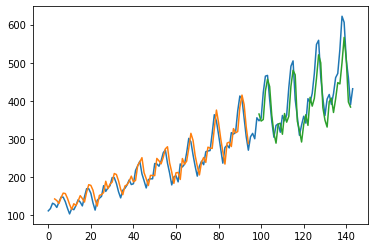

In [1]:
# LSTM for Regression Using the Window Method
    # phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step

# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Epoch 1/100
92/92 - 5s - loss: 0.0722 - 5s/epoch - 55ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0298 - 335ms/epoch - 4ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0208 - 342ms/epoch - 4ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0184 - 326ms/epoch - 4ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0161 - 341ms/epoch - 4ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0138 - 323ms/epoch - 4ms/step
Epoch 7/100
92/92 - 0s - loss: 0.0114 - 289ms/epoch - 3ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0093 - 290ms/epoch - 3ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0074 - 329ms/epoch - 4ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0057 - 312ms/epoch - 3ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0051 - 301ms/epoch - 3ms/step
Epoch 12/100
92/92 - 0s - loss: 0.0043 - 309ms/epoch - 3ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0039 - 324ms/epoch - 4ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0043 - 459ms/epoch - 5ms/step
Epoch 15/100
92/92 - 0s - loss: 0.0042 - 491ms/epoch - 5ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0039 - 456ms/epoc

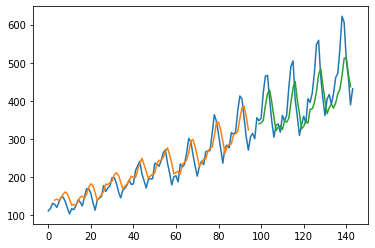

In [3]:
# LSTM for Regression with Time Steps

# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

92/92 - 2s - loss: 0.0074 - 2s/epoch - 24ms/step
92/92 - 0s - loss: 0.0157 - 329ms/epoch - 4ms/step
92/92 - 1s - loss: 0.0089 - 520ms/epoch - 6ms/step
92/92 - 0s - loss: 0.0068 - 235ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0058 - 402ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0054 - 275ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0053 - 256ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0052 - 250ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0051 - 379ms/epoch - 4ms/step
92/92 - 1s - loss: 0.0051 - 532ms/epoch - 6ms/step
92/92 - 1s - loss: 0.0051 - 579ms/epoch - 6ms/step
92/92 - 0s - loss: 0.0050 - 257ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0050 - 333ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0049 - 267ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0049 - 299ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0049 - 262ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0048 - 398ms/epoch - 4ms/step
92/92 - 1s - loss: 0.0048 - 678ms/epoch - 7ms/step
92/92 - 0s - loss: 0.0048 - 261ms/epoch - 3ms/step
92/92 - 1s - loss: 0.0047 - 577ms

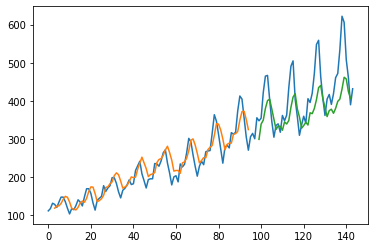

In [4]:
# LSTM with Memory Between Batches

# LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

92/92 - 9s - loss: 0.0050 - 9s/epoch - 94ms/step
92/92 - 0s - loss: 0.0088 - 454ms/epoch - 5ms/step
92/92 - 0s - loss: 0.0066 - 360ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0058 - 365ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0058 - 369ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0059 - 378ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0059 - 371ms/epoch - 4ms/step
92/92 - 1s - loss: 0.0059 - 911ms/epoch - 10ms/step
92/92 - 1s - loss: 0.0059 - 1s/epoch - 12ms/step
92/92 - 1s - loss: 0.0058 - 564ms/epoch - 6ms/step
92/92 - 0s - loss: 0.0058 - 418ms/epoch - 5ms/step
92/92 - 0s - loss: 0.0057 - 441ms/epoch - 5ms/step
92/92 - 0s - loss: 0.0057 - 446ms/epoch - 5ms/step
92/92 - 0s - loss: 0.0056 - 423ms/epoch - 5ms/step
92/92 - 0s - loss: 0.0056 - 473ms/epoch - 5ms/step
92/92 - 1s - loss: 0.0055 - 989ms/epoch - 11ms/step
92/92 - 1s - loss: 0.0055 - 632ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0054 - 662ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0054 - 510ms/epoch - 6ms/step
92/92 - 1s - loss: 0.0053 - 1s/ep

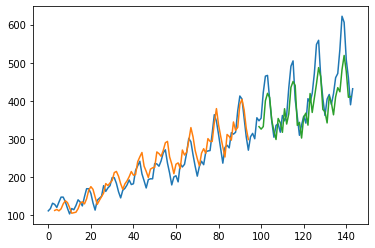

In [5]:
# Stacked LSTMs with Memory Between Batches

# Stacked LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Nursery Rhymes LSTM

In [54]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

# generate a sequence from a language model
def generate_seq(model, tokenizer, max_length, seed_text, n_words):
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# pre-pad sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		# predict probabilities for each word
		yhat = model.predict(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat.any():
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
	return in_text

In [40]:
setting_data = open('nursery_rhymes.txt', 'r')
lines = setting_data.readlines()
data = ''
for i in lines:
  data = data + i
print(data)

THE QUEEN _of_ HEARTS


    The Queen of Hearts she made some tarts,
      All on a summer's day;

    The Knave of Hearts he stole those tarts,
      And took them clean away.

    The King of Hearts called for those tarts,
    And beat the Knave full sore.

    The Knave of Hearts brought back those tarts,
      And vowed he'd steal no more.




SAINT SWITHIN'S DAY


    St. Swithin's day, if thou dost rain,
    For forty days it will remain;
    St. Swithin's day, if thou be fair,
    For forty days 't will rain no more.




DANCE TO YOUR DADDIE


      Dance to your daddie,
      My bonnie laddie,
    Dance to your daddie, my bonnie lamb!
      You shall get a fishie
      On a little dishie,
    You shall get a fishie when the boat comes hame!

      Dance to your daddie,
      My bonnie laddie,
    Dance to your daddie, and to your mammie sing!
      You shall get a coatie,
      And a pair of breekies,
    You shall get a coatie when the boat comes in!




THE MAN IN THE MOON




In [41]:
# prepare the tokenizer on the source text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

In [42]:
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 2408


In [43]:
# create line-based sequences
sequences = list()
for line in data.split('\n'):
	encoded = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(encoded)):
		sequence = encoded[:i+1]
		sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 14115


In [44]:
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)

Max Sequence Length: 16


In [45]:
# split into input and output elements
sequences = array(sequences)
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

In [46]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length-1))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 10)            24080     
                                                                 
 lstm_6 (LSTM)               (None, 50)                12200     
                                                                 
 dense_5 (Dense)             (None, 2408)              122808    
                                                                 
Total params: 159,088
Trainable params: 159,088
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X, y, epochs=500, verbose=2)

Epoch 1/500
442/442 - 12s - loss: 5.9508 - accuracy: 0.0704 - 12s/epoch - 27ms/step
Epoch 2/500
442/442 - 6s - loss: 5.7966 - accuracy: 0.0705 - 6s/epoch - 15ms/step
Epoch 3/500
442/442 - 7s - loss: 5.7007 - accuracy: 0.0743 - 7s/epoch - 15ms/step
Epoch 4/500
442/442 - 7s - loss: 5.6100 - accuracy: 0.0755 - 7s/epoch - 15ms/step
Epoch 5/500
442/442 - 7s - loss: 5.5171 - accuracy: 0.0796 - 7s/epoch - 15ms/step
Epoch 6/500
442/442 - 7s - loss: 5.4226 - accuracy: 0.0844 - 7s/epoch - 16ms/step
Epoch 7/500
442/442 - 7s - loss: 5.3279 - accuracy: 0.0888 - 7s/epoch - 16ms/step
Epoch 8/500
442/442 - 6s - loss: 5.2364 - accuracy: 0.0944 - 6s/epoch - 14ms/step
Epoch 9/500
442/442 - 6s - loss: 5.1478 - accuracy: 0.1006 - 6s/epoch - 14ms/step
Epoch 10/500
442/442 - 6s - loss: 5.0600 - accuracy: 0.1075 - 6s/epoch - 14ms/step
Epoch 11/500
442/442 - 7s - loss: 4.9756 - accuracy: 0.1122 - 7s/epoch - 15ms/step
Epoch 12/500
442/442 - 6s - loss: 4.8933 - accuracy: 0.1185 - 6s/epoch - 14ms/step
Epoch 13/50

In [62]:
# evaluate model
print(generate_seq(model, tokenizer, max_length-1, 'queen', 1))
print(generate_seq(model, tokenizer, max_length-1, 'man', 1))

queen and
man and


In [7]:
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop

In [13]:
# Lowercase all text

setting_data = open('nursery_rhymes.txt', 'r')
lines = setting_data.readlines()
data = ''
for i in lines:
  data = data + i
print("data: ", data)

text = data.lower()
print("text: ", text)

chars = list(set(text))
print(chars)
char_indices = dict((c, i) for i, c in enumerate(chars))
print(char_indices)
indices_char = dict((i, c) for i, c in enumerate(chars))
print(char_indices)

vocab_size = len(chars)
print('Vocabulary size: {}'.format(vocab_size))

data:  THE QUEEN _of_ HEARTS


    The Queen of Hearts she made some tarts,
      All on a summer's day;

    The Knave of Hearts he stole those tarts,
      And took them clean away.

    The King of Hearts called for those tarts,
    And beat the Knave full sore.

    The Knave of Hearts brought back those tarts,
      And vowed he'd steal no more.




SAINT SWITHIN'S DAY


    St. Swithin's day, if thou dost rain,
    For forty days it will remain;
    St. Swithin's day, if thou be fair,
    For forty days 't will rain no more.




DANCE TO YOUR DADDIE


      Dance to your daddie,
      My bonnie laddie,
    Dance to your daddie, my bonnie lamb!
      You shall get a fishie
      On a little dishie,
    You shall get a fishie when the boat comes hame!

      Dance to your daddie,
      My bonnie laddie,
    Dance to your daddie, and to your mammie sing!
      You shall get a coatie,
      And a pair of breekies,
    You shall get a coatie when the boat comes in!




THE MAN IN THE 

In [14]:
# Data preparation
X = [] # training array
Y = [] # target array

length = len(text)
seq_length = 100 # number of characters to consider before predicting a character

# Iterate over length of text and create sequences stored in X, true values stored in Y
# true values being which character would actually come after sequence stored in X
for i in range(0, length - seq_length, 1):
    sequence = text[i:i + seq_length]
    label = text[i + seq_length]
    X.append([char_indices[char] for char in sequence])
    Y.append(char_indices[label])

print('Number of sequences: {}'.format(len(X)))

Number of sequences: 102862


In [15]:
# Reshape dimensions
X_new = np.reshape(X, (len(X), seq_length, 1))
# Scale values
X_new = X_new/float(len(chars))
# One-hot encode Y to remove ordinal relationships
Y_new = np_utils.to_categorical(Y)

X_new.shape, Y_new.shape

((102862, 100, 1), (102862, 40))

In [16]:
model = Sequential()
# Add LSTM layer to compute output using 150 LSTM units
model.add(LSTM(150, input_shape = (X_new.shape[1], X_new.shape[2]), return_sequences = True))

# Add regularization layer to prevent overfitting.
# Dropout ignores randomly selected neurons during training ("dropped out").
# Ultimately, network becomes less sensitive to specific weights of neurons --> network is better at generalization.
model.add(Dropout(0.1))

model.add(Flatten())
# Dense layer with softmax activation function to approximate probability distribution of next best word
model.add(Dense(Y_new.shape[1], activation = 'softmax'))

# Compile model to configure learning process
# Categorical crossentropy: an example can only belong to one class
# Adam optimization algorithm updates a learning rate for each network weight iteratively as learning unfolds
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Use 1 epoch for sake of computational time
model.fit(X_new, Y_new, epochs = 1, verbose = 1)

3215/3215 [==============================] - 552s 170ms/step - loss: 2.8424


In [18]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 150)          91200     
                                                                 
 dropout_2 (Dropout)         (None, 100, 150)          0         
                                                                 
 flatten (Flatten)           (None, 15000)             0         
                                                                 
 dense_3 (Dense)             (None, 40)                600040    
                                                                 
Total params: 691,240
Trainable params: 691,240
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# Random start
start = np.random.randint(0, len(X)-1)
string_mapped = list(X[start])
full_string = [indices_char[value] for value in string_mapped]

# Generate text
for i in range(400):
    x = np.reshape(string_mapped, (1, len(string_mapped), 1))
    x = x / float(len(chars))
    
    pred_index = np.argmax(model.predict(x, verbose = 0))
    seq = [indices_char[value] for value in string_mapped]
    full_string.append(indices_char[pred_index])
    
    string_mapped.append(pred_index)
    string_mapped = string_mapped[1:len(string_mapped)]
    
# Combine text
newtext = ''
for char in full_string:
    newtext = newtext + char

print(newtext)

stile;
    and i sha'n't get home to-night."

    but the rat would not.

she went a little farther                                                                                                                                                                                                                                                                                                                                                                                                                 
